# SDCA

Ce notebook présente une implementation du Stochastic Dual Coordinate Ascente pour la Hinge loss (SVM) tel qu'il est décrit dans le papier [Shalev-Schwartz et al](http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf) et la comparaison de ses performances avec un algorithme de type SGD: [Pegasos](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf).

Projet fait pour le cours de Stochastic Optimization and Automatic Differentiation for Machine Learning de M. Cuturi suivi à ENSAE ParisTech.

[Implementation](#Implementation)

[Experiences pour $\lambda$ différents sur le dataset Adults](#Adults-data)
[Experiences sur le dataset giselle](#

In [10]:
import numpy as np
import scipy
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.svm import LinearSVC

# Implementation


In [12]:

def Primal(X, y, w, lmd=1):
    """
    Primal problem loss
    """
    n = y.shape[0]
    X_w = X.dot(w)
    ys = scipy.sparse.diags(y)

    mx = np.maximum(np.zeros((n, 1)), 1 - ys.dot(X.dot(w)))
    mx = np.float(np.ones((1, n)).dot(mx) / n)
    return mx + lmd / 2 * np.float(w.T.dot(w))


def Dual(X, y, alpha, lmd=1):
    """
    Dual problem loss
    """
    n = y.shape[0]
    alphas = scipy.sparse.diags(alpha[:, 0])
    phi_star = alphas.dot(y).mean()
    w = 1 / (lmd * n) * alphas.dot(X).sum(axis=0).T
    return phi_star - lmd / 2 * np.float(w.T.dot(w))


def Class(X, y, w):
    """
    Classification error
    """
    y_pred = np.sign(
        X.dot(w))  # takes a lot of time for sparse matrixes, maybe could be optimized
    return np.linalg.norm(y_pred - y, ord=1) / (2 * y.shape[0])

In [28]:
def sdca(X, y, n_iter, lmd=1, option="high_prob", indexes="random", T_0=0, save_loss=500, P=True, D=True, C_train=False, C_test=False, X_test=None, y_test=None):
    """
    X : training points in scipy sparse matrix format (typically coming from a libsvm format)
    y : labels, sparse matrix
    n_iter : number of iterations
    T_0 : the last iteration not taken into the account, used only if option!="high_prob"
    lmd: regularization parameter
    option : "average", "random" as in the article; "high_prob" returns just the last value
    indexes : if "random" at each iteration i is sampled at random, otherwise i = indexes[itr]
    save_loss : save loss every .. iteration
    P, D, C_train, C_test : indicates which loss to save, respectively Primal, Dual, 
                            classification error on training and testing set
    X_test, y_test : testing points and labels
    """
    # initialization
    n, p = X.shape
    alpha, w = np.zeros((n, 1)), np.zeros((p, 1))
    if indexes == "random":
        indexes = np.random.randint(n, size=n_iter)
    if option != "high_prob":
        # save alphas if option is average or random
        alphas = np.zeros((n_iter - T_0, n))

    Primal_loss = []
    Dual_loss = []
    Class_train = []

    # testing error
    Class_test = []

    # iter
    for itr in range(n_iter):
        i = indexes[itr]

        # takes a lot of time for sparse matrixes, could maybe be optimized
        norm_x = X[i].multiply(X[i]).sum(1)
        norm_x = np.float(norm_x)

        X_w = np.float(X[i].dot(w))
        delta_alpha_i = y[i] * max(0, min(1, (1 - y[i] * X_w)
                                          * lmd * n / norm_x + alpha[i, 0] * y[i])) - alpha[i, 0]

        alpha[i, 0] += delta_alpha_i

        w += 1 / (lmd * n) * delta_alpha_i * X[i].T

        if option != "high_prob" and itr >= T_0:
            # starts saving values of alpha
            alphas[itr - T_0] = alpha.copy()

        if itr % save_loss == 0:
            # history of losses
            if P:
                Primal_loss.append(Primal(X, y, w, lmd))
            if D:
                Dual_loss.append(Dual(X, y, alpha, lmd))
            if C_train:
                Class_train.append(Class(X, y, w))
            if C_test:
                Class_test.append(Class(X_test, y_test, w))
    # recalculate alpha and w if option is "average" or "random"
    if option == "average":
        alpha = np.mean(alphas, axis=0)
        w = 1 / (lmd * n) * X.T.dot(scipy.sparse.diags(alpha)).sum(axis=1)
    elif option == "random":
        i = np.random.randint(n_iter - T_0)
        alpha = alphas[i]
        w = 1 / (lmd * n) * X.T.dot(scipy.sparse.diags(alpha)).sum(axis=1)

    return alpha, w, Primal_loss, Dual_loss, Class_train, Class_test

In [29]:
def Pegasos(X, y, n_iter, lmd, save_loss=500, indexes="random", P=True, C_train=False, C_test=False, X_test=None, y_test=None):
    """
    X : training points in scipy sparse matrix format (typically coming from a libsvm format)
    y : labels, sparse matrix
    n_iter : number of iterations
    lmd: regularization parameter
    save_loss : save loss every .. iteration
    indexes : if None at each iteration i is sampled at random, otherwise i = indexes[itr]
    P, C_train, C_test : indicates which loss to save, respectively Primal, 
                         classification error on training and testing set
    X_test, y_test : testing points and labels same format as X and y
                     should be provided if C_test is True
    """
    # initialization
    n, p = X.shape
    if indexes == "random":
        indexes = np.random.randint(n, size=n_iter)
    w = np.zeros((p, 1))
    Primal_loss = []
    Class_train = []
    Class_test = []
    # iter
    for itr in range(n_iter):
        i = indexes[itr]
        step = 1 / (lmd * (itr + 1))
        y_Xw = y[i] * np.float(X[i].dot(w))
        w = (1 - 1 / (itr + 1)) * w + step * (1 > y_Xw) * y[i] * X[i].T
        if itr % save_loss == 0:
            if P:
                Primal_loss.append(Primal(X, y, w, lmd))
            if C_train:
                Class_train.append(Class(X, y, w))
            if C_test:
                Class_test.append(Class(X_test, y_test, w))
    return w, Primal_loss, Class_train, Class_test

get a libsvm type data

In [4]:
from sklearn.datasets import load_svmlight_file


def get_data(path):
    data = load_svmlight_file(path)
    return data[0], data[1]

## Adults data

In [543]:
PATH_train, PATH_test = "a7a", "a7a.t"

In [544]:
X_train, y_train = get_data(PATH_train)
#X_test, y_test = get_data(PATH_test)
X_train.shape, X_test.shape

((16100, 122), (16461, 123))

Calculate data density

In [545]:
s = X_train.nnz / (X_train.shape[0] * X_train.shape[1])
s

0.11368699725078912

## $\lambda = 1$

In [550]:
lmd = 1
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

Calculate the theoretical dual gap bound as following:

Theorem 2 + Remark 4 of the paper tells us that if we have ($L=1$ for Hinge Loss):
$$ T \geq \max (0, \lceil n \log (0.5 \lambda n) \rceil) + n + \frac{5}{\lambda^2 \epsilon_P} $$
Then with high probability:
$$ P(w) - D(\alpha) \leq \epsilon_P$$

Therefore the bound is $+ \infty$ when $t\leq \max (0, \lceil n \log (0.5 \lambda n) \rceil) + n$ and equal to $$\frac{5}{(\lambda(t  - \max (0, \lceil n \log (0.5 \lambda n) \rceil) -n)}$$ afterwards

In [551]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1]

1.5522936691254998e-05

To get the optimal value $P(w^*) = D(\alpha^*)$ I take the value calculated by the scikit solver.

Since it solves the following optimization problem:
$$w^* = \arg \min _{w} \frac{1}{2} ||w||_2^2 + C \sum_{i=1}^n \phi_i(w^Tx_i)$$

We have $C_{scikit} = \frac{1}{\lambda n}$

In [552]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.5714329281076667

In [553]:
w, alpha, P, D, C, C2 = sdca(X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [554]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss)

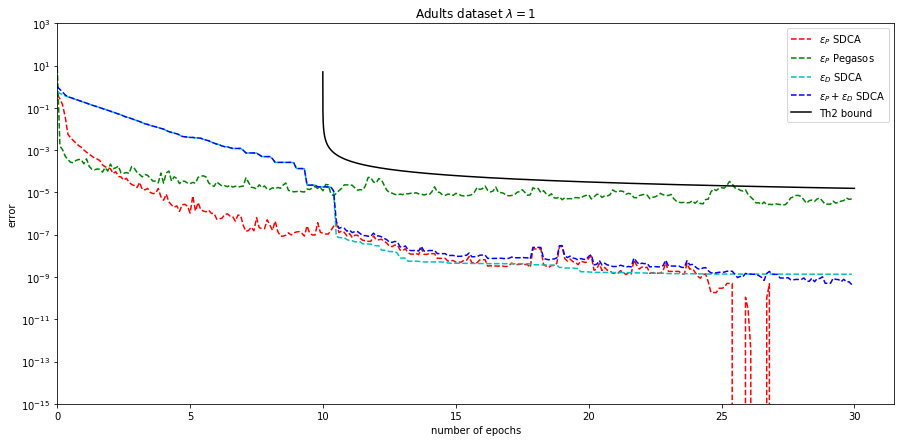

In [555]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-15), 10**3))
plt.xlim(0)
plt.title("Adults dataset $\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

## $\lambda=10^{-2}$

In [557]:
lmd = 1e-2
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

In [558]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(0.0012618360218852839, 86751.0)

In [559]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.3847875383535503

In [560]:
w, alpha, P, D, C, C2 = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [561]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss)

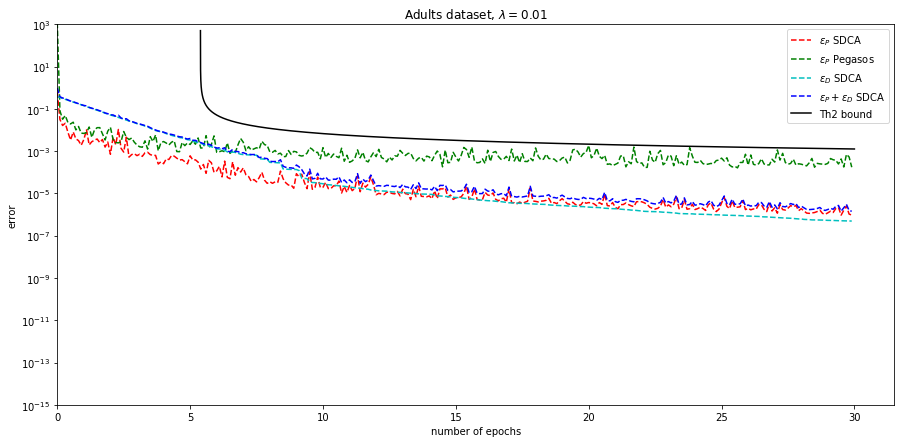

In [562]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-15), 10**3))
plt.xlim(0)
plt.title("Adults dataset, $\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

## $\lambda=10^{-4}$

In [564]:
lmd = 1e-4
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

In [565]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(0.10708954184952206, 16100.0)

In [566]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.35442059102439527

In [567]:
w, alpha, P, D, C, C2 = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [568]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss)

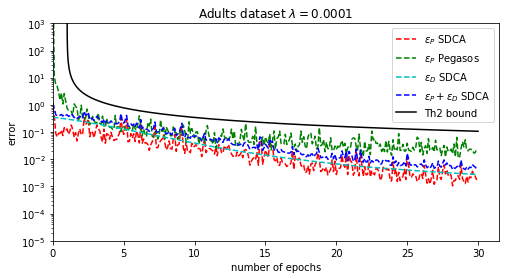

In [578]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-5), 10**3))
plt.xlim(0)
plt.title("Adults dataset $\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

# Gisette

In [451]:
PATH_train, PATH_test = "gisette_scale", "gisette_scale.t"

In [452]:
X_train, y_train = get_data(PATH_train)
X_test, y_test = get_data(PATH_test)
X_train.shape, X_test.shape

((6000, 5000), (1000, 5000))

Normalize features to get the same bounds as in the article

In [453]:
X_norm = np.linalg.norm(X_train.toarray(), axis=0, ord=2)
X_train = X_train.dot(scipy.sparse.diags(1 / (X_norm + 1e-12)))
X_test = X_test.dot(scipy.sparse.diags(1 / (X_norm + 1e-12)))

In [454]:
s = X_train.nnz / (X_train.shape[0] * X_train.shape[1])
s

0.9909999

## $\lambda=1$

In [455]:
lmd = 1
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

In [456]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1]

3.969514131470308e-05

In [460]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.9975051915711495

In [461]:
w, alpha, P, D, C, C2 = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [462]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss)

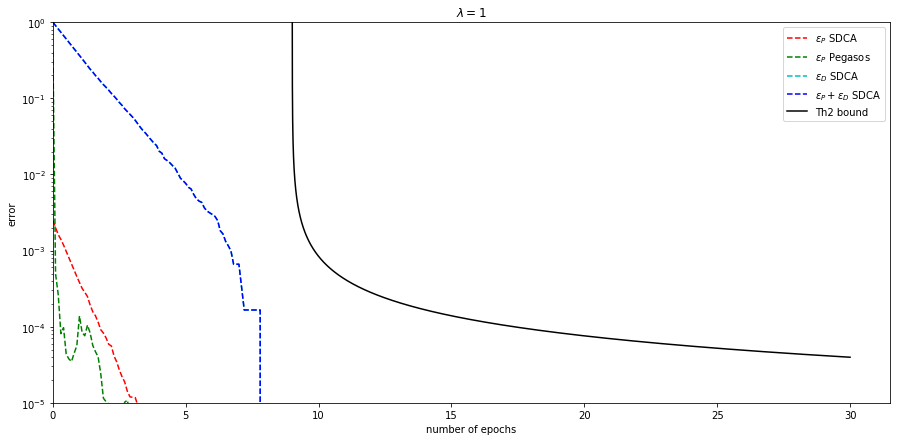

In [463]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-5), 1))
plt.xlim(0)
plt.title("$\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

## $\lambda=0.01$

In [482]:
lmd = 1e-2
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

In [483]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(0.00325539907937314, 26408.0)

In [484]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
C_train_scikit = Class(X_train, y_train, w_scikit)
C_test_scikit = Class(X_test, y_test, w_scikit)
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.7626783072593277

In [485]:
w, alpha, P, D, C, C2 = sdca(X_train, y_train, n_iter=n_iter, option="high_prob",
                             lmd=lmd, save_loss=save_loss, C_test=True, X_test=X_test, y_test=y_test)

In [486]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss, C_test=True, X_test=X_test, y_test=y_test)

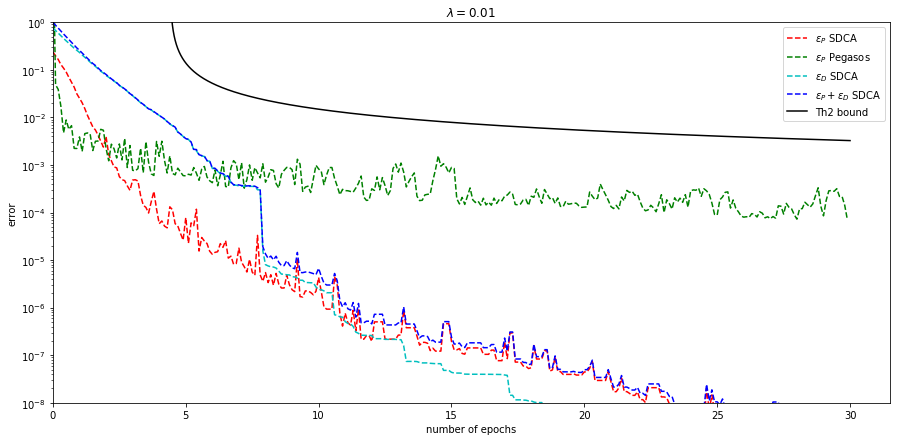

In [487]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-8), 1))
plt.xlim(0)
plt.title("$\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

## $\lambda=10^{-4}$

In [489]:
lmd = 1e-4
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

epoch = y_train.shape[0]
n_iter = 30 * epoch
save_loss = int(epoch / 10)

In [490]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(0.2873579733216857, 6000.0)

In [491]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.14894004198169225

In [492]:
w, alpha, P, D, C, C2 = sdca(X_train, y_train, n_iter=n_iter, option="high_prob",
                             lmd=lmd, save_loss=save_loss, C_test=True, X_test=X_test, y_test=y_test)

In [493]:
w_peg, P_peg, C_peg, C2_peg = Pegasos(
    X_train, y_train, n_iter=n_iter, lmd=lmd, save_loss=save_loss, C_test=True, X_test=X_test, y_test=y_test)

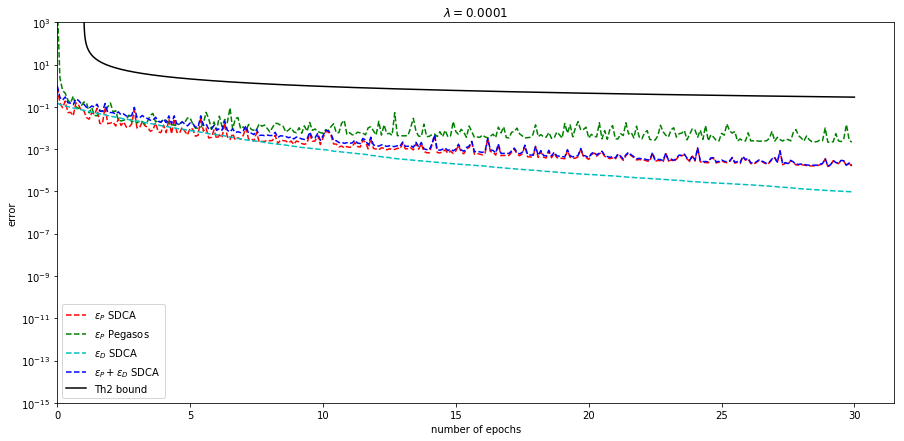

In [494]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - P_star, "r--", label="$\epsilon_P$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_peg) -
         P_star, "g--", label="$\epsilon_P$ Pegasos")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, P_star -
         np.array(D), "c--", label="$\epsilon_D$ SDCA")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P) -
         np.array(D), "b--", label="$\epsilon_P + \epsilon_D$ SDCA")
plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
         dual_gap_bound, "black", label="Th2 bound")
plt.ylim((10**(-15), 10**3))
plt.xlim(0)
plt.title("$\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

# Perm, Cycle or Random

Check the diference between when indexes are chose at random, permutatio or cycles

In [7]:
PATH_train = "a7a"
X_train, y_train = get_data(PATH_train)

In [43]:
lmd = 1
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

nb_epochs = 15
epoch = y_train.shape[0]
n_iter = nb_epochs * epoch
save_loss = int(epoch / 10)

In [44]:
cycle_ind = np.tile(np.random.choice(
    np.arange(epoch), size=epoch, replace=False), nb_epochs)
perm_ind = np.random.randint(epoch, size=epoch)
for i in range(nb_epochs - 1):
    perm_ind = np.concatenate((perm_ind, np.random.randint(epoch, size=epoch)))

In [45]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(6.203166095975386e-05, 160895.0)

In [46]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.5714329305583734

In [47]:
w_cycle, alpha_cycle, P_cycle, D_cycle, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss, indexes=cycle_ind)

/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [48]:
w, alpha, P, D, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [49]:
w_perm, alpha_perm, P_perm, D_perm, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss, indexes=perm_ind)

/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


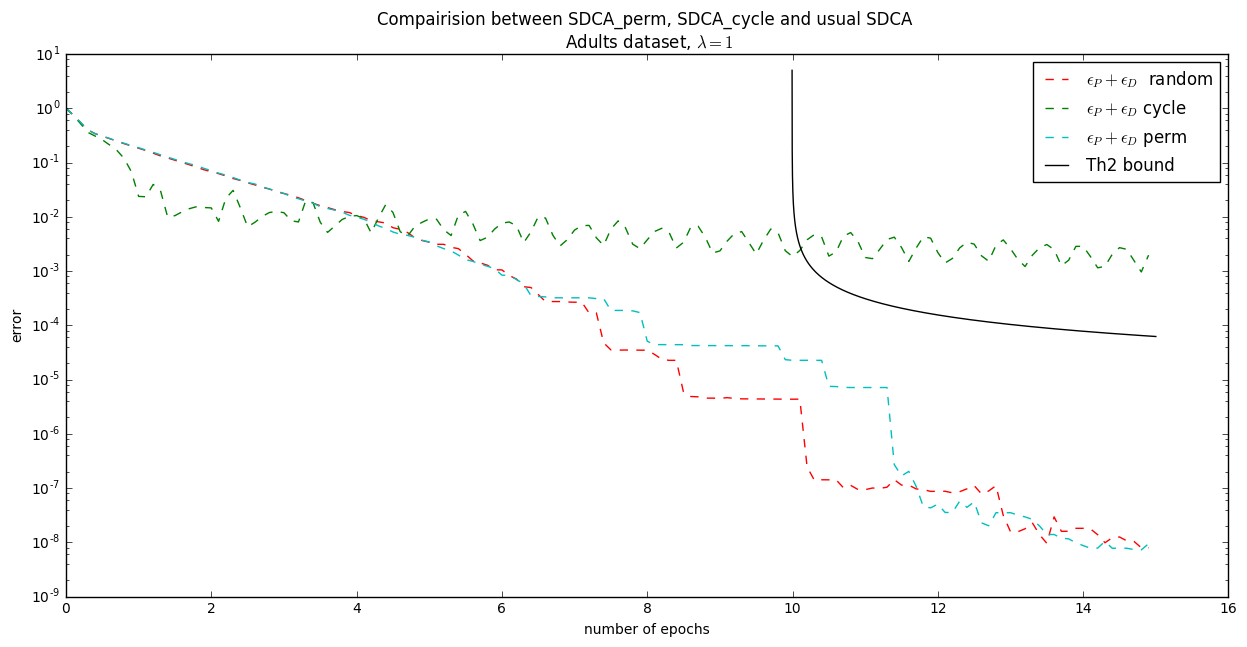

In [52]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - np.array(D), "r--", label="$\epsilon_P + \epsilon_D$  random")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_cycle) -
         np.array(D_cycle), "g--", label="$\epsilon_P + \epsilon_D$ cycle")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_perm) -
         np.array(D_perm), "c--", label="$\epsilon_P + \epsilon_D$ perm")

plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
             dual_gap_bound, "black", label="Th2 bound")
#plt.ylim((10**(-15), 10**3))
plt.xlim(0)
plt.title("Compairision between SDCA_perm, SDCA_cycle and usual SDCA \n Adults dataset, $\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")

In [53]:
lmd = 1e-2
n = y_train.shape[0]
C_scikit = 1 / (lmd * n)

nb_epochs = 15
epoch = y_train.shape[0]
n_iter = nb_epochs * epoch
save_loss = int(epoch / 10)

In [54]:
cycle_ind = np.tile(np.random.choice(
    np.arange(epoch), size=epoch, replace=False), nb_epochs)
perm_ind = np.random.randint(epoch, size=epoch)
for i in range(nb_epochs - 1):
    perm_ind = np.concatenate((perm_ind, np.random.randint(epoch, size=epoch)))

In [55]:
l = np.ceil(max(0, n * np.log(0.5 * lmd * n))) + n
dual_gap_bound = [np.inf for i in range(int(l) + 1)]
for i in range(int(l) + 1, n_iter):
    dual_gap_bound.append(5 / (lmd * (i - l)))
dual_gap_bound[-1], l

(0.003231059529040763, 86751.0)

In [56]:
clf = LinearSVC(fit_intercept=False, loss="hinge", max_iter=n_iter, C=C_scikit)
clf.fit(X_train, y_train)
w_scikit = clf.coef_.T 
P_star = Primal(X_train, y_train, w_scikit, lmd)
P_star

0.3847875372173

In [57]:
w_cycle, alpha_cycle, P_cycle, D_cycle, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss, indexes=cycle_ind)

/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [58]:
w, alpha, P, D, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss)

In [59]:
w_perm, alpha_perm, P_perm, D_perm, _, _ = sdca(
    X_train, y_train, n_iter=n_iter, option="high_prob", lmd=lmd, save_loss=save_loss, indexes=perm_ind)

/home/sel/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


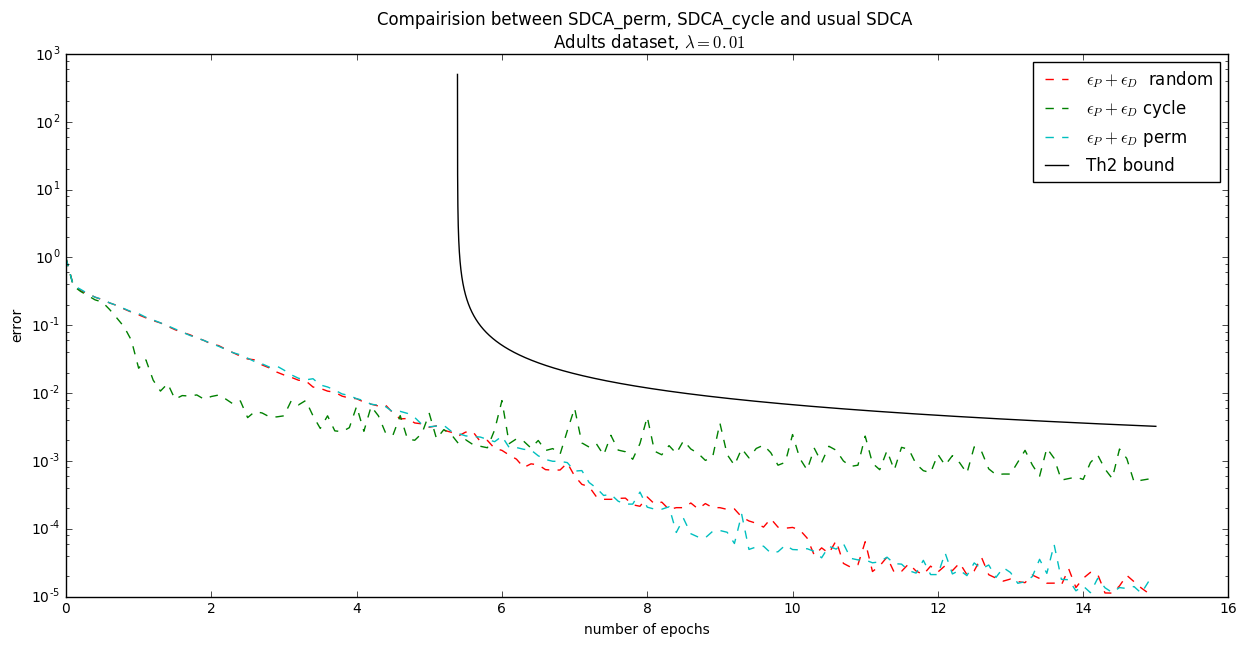

In [60]:
plt.figure(figsize=(15, 7))
plt.plot(np.arange(0, n_iter, save_loss) / epoch,
         np.array(P) - np.array(D), "r--", label="$\epsilon_P + \epsilon_D$  random")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_cycle) -
         np.array(D_cycle), "g--", label="$\epsilon_P + \epsilon_D$ cycle")
plt.plot(np.arange(0, n_iter, save_loss) / epoch, np.array(P_perm) -
         np.array(D_perm), "c--", label="$\epsilon_P + \epsilon_D$ perm")

plt.plot(np.arange(0, len(dual_gap_bound)) / epoch,
             dual_gap_bound, "black", label="Th2 bound")
#plt.ylim((10**(-15), 10**3))
plt.xlim(0)
plt.title("Compairision between SDCA_perm, SDCA_cycle and usual SDCA \n Adults dataset, $\lambda = {}$".format(lmd))
plt.ylabel("error")
plt.xlabel("number of epochs")
plt.legend()
plt.yscale("log")